In [25]:
import os
os.chdir('C:\\Users\\Vinim\\Documents\\github\\tcc_vinicius')

import pandas as pd
from data_processing.y_finance import Stocks
from datetime import date
import matplotlib.pyplot as plt

In [26]:
convercao= {'petro':   'Company: Petrobras | Ticket: PETR4',
            'vale':    'Company: Vale | Ticket: VALE3',
            'itau':    'Company: Itaú Unibanco | Ticket: ITUB4',
            'ambev':   'Company: Ambev | Ticket: ABEV3',
            'weg':     'Ticket: WEGE3 - company name: WEG',
            'bradesco':'Company: Banco Bradesco | Ticket: BBDC4',
            'banco do brasil':'Company: Banco do Brasil | Ticket: BBAS3',
            'btg':     'Company: Banco BTG Pactual | Ticket: BPAC11',
            'santander':'Company: Banco Santander | Ticket: SANB3',
            'itausa':  'Company: Itaúsa | Ticket: ITSA4'}

In [27]:
ambev = Stocks('ABEV3')
petro = Stocks('PETR4')
vale = Stocks('VALE3')
itau = Stocks('ITUB4')
weg = Stocks('WEGE3')
bradesco = Stocks('BBDC4')
banco_brasil = Stocks('BBAS3')
btg = Stocks('BPAC11')
santander = Stocks('SANB3')
itausa = Stocks('ITSA4')

In [28]:
lista_acoes =[petro, vale, itau, ambev, weg, bradesco, banco_brasil, btg, santander, itausa]
start_date = '2024-01-10'
end_date = date.today () # '2024-03-12' 

for i in lista_acoes:
    i.get_price_historic(start_date=start_date,
                         end_date=end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## correlçaão

In [29]:
def check_sentiment_type(value):
    try:
      value = float(value)
    except:
       value = 0
    return value  

df = pd.read_parquet('result_processing//news_sentiment_v2.parquet')


df['sentiment score'].fillna(0, inplace=True)
df['sentiment score'] = df['sentiment score'].apply(check_sentiment_type)
df['sentiment score'] = df['sentiment score'].astype(int)
df.loc[df['sentiment score'] > 5, 'sentiment score'] = 5 
df.loc[df['sentiment score'] < -5, 'sentiment score'] = -5

In [30]:
# df = pd.read_csv("planilhas//df_sample_march_full_2.csv", index_col=0)
df['datePublished'] = pd.to_datetime(df['datePublished'])
df['datePublished'] = df['datePublished'].dt.date

# retirar dados que contenha IBOVESPA
filtro_ibovespa  = df['name'].str.upper().str.contains('IBOVESPA')
# df.loc[filtro_ibovespa, ['name','full_text', 'key', 'relevance']].sample(2).values
df.loc[filtro_ibovespa, 'relevance'] = 0

# filtragem de notícias classificadas de forma adequada
df = df[df['relevance'] == 1].copy()

# remoção dos valores de sentimentos que não foi retornado como número
df['sentiment score'] = pd.to_numeric(df['sentiment score'], errors='coerce')
df = df[df['sentiment score'].notna()].copy()

# positivo
df.loc[df['sentiment score'] > 0, 'sentiment score positive'] = df.loc[df['sentiment score'] > 0, 'sentiment score']
df['sentiment score positive'].fillna(0,inplace=True)

# negativo
df.loc[df['sentiment score'] < 0, 'sentiment score negative'] = df.loc[df['sentiment score'] < 0, 'sentiment score']
df['sentiment score negative'].fillna(0,inplace=True)

In [31]:
def min_max_scaling(data):
    min_val = min(data)
    max_val = max(data)
    scaled_data = [(x - min_val) / (max_val - min_val) for x in data]
    return scaled_data

def sentiment_company(df, company_name):
    df_company = df[df['key_standard'] == convercao[company_name]].reset_index(drop=True).copy()

    grouped = df_company.groupby(['datePublished','key_standard']).agg({'sentiment score':['count', 'mean', 'sum','median', 'max', 'min'],
                                                                'sentiment score positive': 'sum',
                                                                'sentiment score negative': 'sum' })
    grouped.reset_index(inplace=True)
    grouped.columns = grouped.columns.droplevel(0)

    columnas_name = ['datePublished', 'key_standard', 'sentiment score_count',
                    'sentiment score_mean', 'sentiment score_sum', 'sentiment score_median', 
                    'sentiment score_max', 'sentiment score_min', 
                    'score positive_sum', 'score negative_sum']

    grouped.columns = columnas_name
    grouped.set_index('datePublished', inplace=True)
    grouped.index = pd.to_datetime(grouped.index)

    grouped = grouped[['sentiment score_mean', 'sentiment score_sum', 'score positive_sum', 'score negative_sum']].copy()
    grouped['pct_sentiment_score_mean'] = grouped['sentiment score_mean'].pct_change()
    grouped['sum_normalized'] = min_max_scaling(grouped['sentiment score_sum'])
    

    return grouped 

In [32]:
def calculate_correlation_return_sentiment(stock_series, sentiment_series, lag_range, round_n):
    
    comparison_df = pd.DataFrame({'sentiment': sentiment_series, 'stock price': stock_series})
    comparison_df['stock price'] = comparison_df['stock price'].ffill()

    correlation_dict = dict()
    
    for lag in range(lag_range[0], lag_range[1],1):
        comparison_df['stock price_lag'] = comparison_df['stock price'].shift(lag)
        df_correlation = comparison_df.corr()
        correlation = df_correlation.loc['sentiment', 'stock price_lag']
        correlation_dict[lag] = round(correlation, round_n)
    
    return correlation_dict


def plot_line_graph_from_dict(data_dict, label_name):
    
    # Separando as chaves e valores do dicionário
    lags = list(data_dict.keys())
    valores = list(data_dict.values())

    # Criando o gráfico de linha
    plt.plot(lags, valores, marker='o', linestyle='-', label=label_name)

In [33]:
import matplotlib.pyplot as plt

# Definindo o ciclo de cores personalizado
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=CB_color_cycle)

>petro
>vale
>itau
>ambev
>bradesco
>banco do brasil
>btg
>santander
>itausa


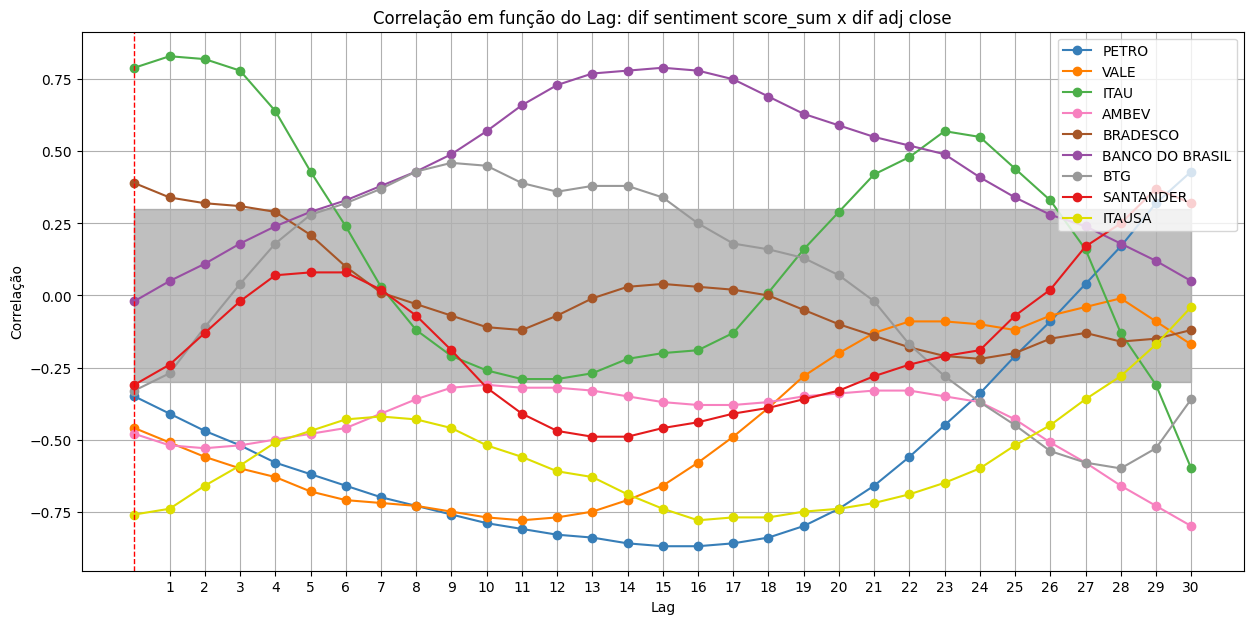

In [130]:
lag_range = (0,31)
round_n = 2

# col_sentiment = 'sentiment score_mean'
col_sentiment = 'sentiment score_sum'
# col_sentiment = 'score negative_sum'
# col_sentiment = 'sum_normalized'

# col_price = 'price_variation'
col_price = 'adj close'

automacao = {'petro':  petro ,
            'vale':    vale,
            'itau':    itau,
            'ambev':   ambev,
            'weg':     weg,
            'bradesco':bradesco,
            'banco do brasil':banco_brasil,
            'btg':     btg,
            'santander':santander,
            'itausa':  itausa}

automacao = {
            'petro':  petro ,
            'vale':    vale,
            'itau':    itau,
            'ambev':   ambev,
            'bradesco':bradesco,
            'banco do brasil':banco_brasil,
            'btg':     btg,
            'santander':santander,
            'itausa':  itausa
            }

plt.figure(figsize=(15, 7))

plt.title(f'Correlação em função do Lag: dif {col_sentiment} x dif {col_price}')

for key, value in automacao.items():
    print(f'>{key}')
    sentiment_com = sentiment_company(df, key)
    sentiment_series = sentiment_com[col_sentiment].rolling(7).mean()
    stock_series = value.price[col_price].rolling(7).mean()
    corr_dict_com = calculate_correlation_return_sentiment(stock_series, sentiment_series, lag_range, round_n)

    plot_line_graph_from_dict(corr_dict_com, key.upper())



plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
plt.fill_between(list(corr_dict_com.keys()),-0.3, 0.3, color='gray', alpha=0.5)


plt.xlabel('Lag')
plt.ylabel('Correlação')
plt.grid(True)
plt.xticks(range(1, 31))

plt.legend()
plt.show()
# corr_dict_com

* Quando o lag > 0 estou comparando o preço n dias depois do sentimento

* Quando o lag <0 estou comparando o preço n dias antes do sentimento

In [35]:
filtro_comp = (df['key_standard'] == 'Company: Vale | Ticket: VALE3')

## 2. Análise curva de sentimentos e preço

In [89]:
n = 7
key = 'itau'

In [90]:
df_stock = itau.price
df_stock['adj close sma'] = df_stock['adj close'].rolling(n).mean()

sentiment_com = sentiment_company(df, key)
sentiment_com['sentiment score_sum sma'] = sentiment_com['sentiment score_sum'].rolling(n).mean()

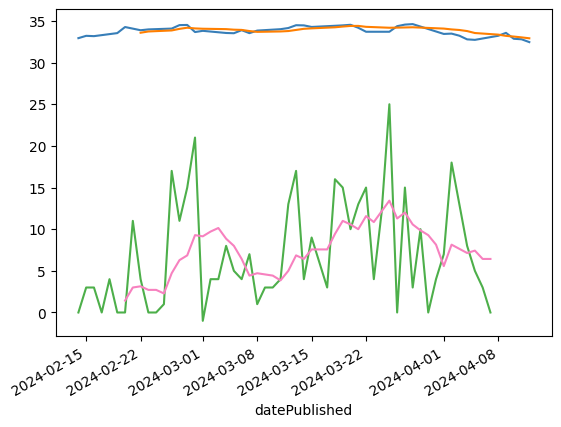

In [129]:
df_stock['adj close'].plot(label = 'adj close')
df_stock['adj close sma'].plot(label = 'adj close media movel')

sentiment_com['sentiment score_sum'].plot(label = 'sentimento')
sentiment_com['sentiment score_sum sma'].plot(label = 'sentimento media movel')

plt.show()

## 3. Criar modelo de auto regressão com melhores fatores 

### Modelo itau

In [94]:
itau = Stocks('ITUB4')
sentiment = sentiment_company(df, 'itau')


start_date = '2024-02-10'
end_date = date.today () # '2024-03-12' 
itau.get_price_historic(start_date=start_date,
                         end_date=end_date)
price = itau.price

[*********************100%%**********************]  1 of 1 completed


* média movel

In [96]:
price['adj close sma'] = price['adj close'].rolling(n).mean()

sentiment['sentiment score_sum sma'] = sentiment['sentiment score_sum'].rolling(n).mean()

* vizualização

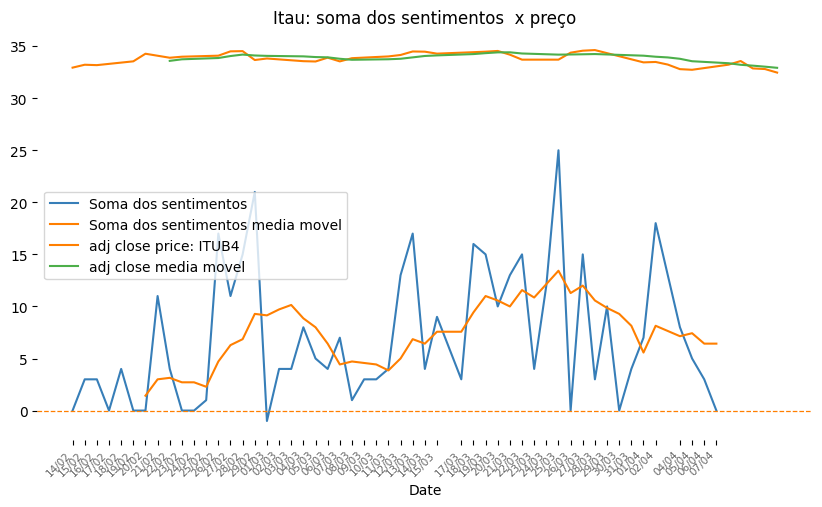

In [98]:
fig, ax = plt.subplots(figsize= (10,6))    
x = sentiment.index
x_ajusted = [j.strftime("%d/%m") for j in list(x)]

color_0 = '0.4'

ax.plot(x,sentiment['sentiment score_sum'], label='Soma dos sentimentos')
ax.plot(x,sentiment['sentiment score_sum sma'], color='#ff7f00', label='Soma dos sentimentos media movel')

# ax.plot(x, sentiment['sentiment score_mean'], color='#984ea3', label='Média dos sentimentos')
# ax.plot(x,sentiment['score negative_sum'], color='darkred', label='Soma dos sentimentos negativos')
# ax.plot(x,sentiment['sum_normalized'], color='#ff7f00', label='Soma dos sentimentos normalizados')


itau.plot_price(ax)
price['adj close sma'].plot(label = 'adj close media movel')

# itau.plot_pct_change(ax)
ax.legend(title='', loc='best')

ax.axhline(y=0, color='#ff7f00', linestyle='--', lw=0.9)

# date_range = [start_date + datetime.timedelta(days=x) for x in range((end_date - start_date).days)+1]
ax.set_xticks(x)
ax.set_xticklabels(labels=x_ajusted,rotation=45, ha='right', fontsize=7.5, color=color_0)

# ax.grid()
ax.legend(loc='best')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


ax.set_title("Itau: soma dos sentimentos  x preço")
plt.show()

* unificação dos dados

In [99]:
df_itau = pd.merge(sentiment, price, left_index=True, right_index=True, how='outer')


In [101]:
# df_itau = df_itau[['adj close','sentiment score_sum']].copy()
df_itau = df_itau[['adj close sma','sentiment score_sum sma']].copy()
df_itau.interpolate(method='linear', inplace=True)

* treino e teste

In [103]:
cutoff_index = int(df_itau.shape[0] * 0.9)
df_train = df_itau.iloc[:cutoff_index]
df_test = df_itau.iloc[cutoff_index:]

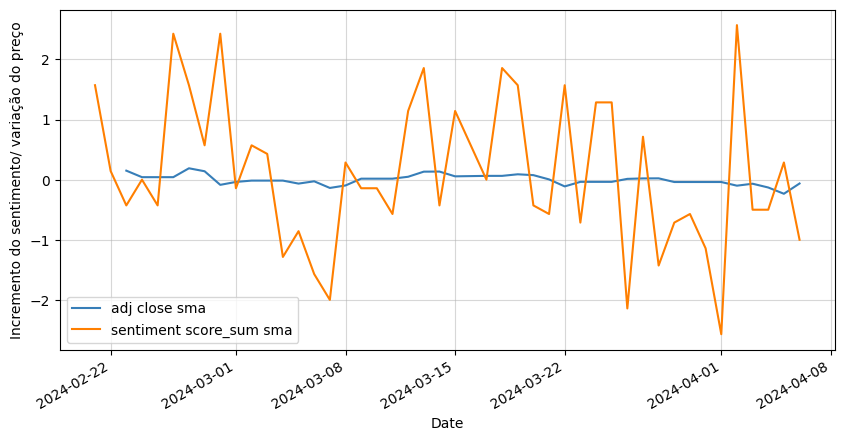

In [104]:
# Apply differencing
df_diff = df_train.diff()

# Plot results
df_diff.plot(figsize=(10,5))
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Incremento do sentimento/ variação do preço')
plt.show()

In [111]:
df_diff = df_diff[9:]

In [106]:
import autoregressive_model as arm
def valdiacao_estacionariedade(data):
    # Teste de Dickey-Fuller Aumentado (ADF)
    adf_result = arm.teste_estacionariedade(data, 'adf')
    print('\n-----------------------------')

    # Teste KPSS
    kpss_result = arm.teste_estacionariedade(data, 'kpss')
    print('\n-----------------------------')

In [113]:
from statsmodels.tsa.stattools import adfuller

for variable in df_diff.columns:

    # Perform the ADF test
    valdiacao_estacionariedade(df_diff[variable])

O valor-p do teste ADF é: 0.0152
A série parece ser estacionária com base no teste ADF.
A estatistica de teste é -3.291856642703251

-----------------------------
O valor-p do teste KPSS é: 0.0783
A série parece ser não estacionária com base no teste KPSS.
A estatistica de teste é 0.3972761950200698

-----------------------------
O valor-p do teste ADF é: 0.0061
A série parece ser estacionária com base no teste ADF.
A estatistica de teste é -3.582298955730662

-----------------------------
O valor-p do teste KPSS é: 0.1
A série parece ser não estacionária com base no teste KPSS.
A estatistica de teste é 0.19312973524652507

-----------------------------


C:\Users\Vinim\Documents\github\tcc_vinicius\autoregressive_model.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = teste(series)


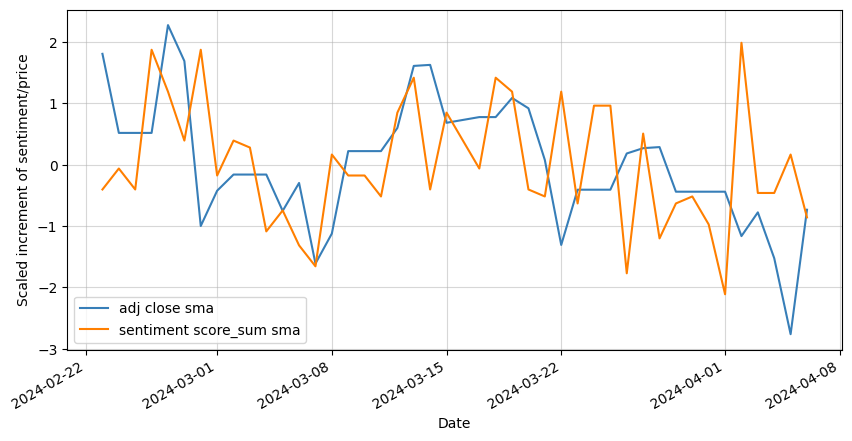

In [114]:
 # Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Transform data
scaled_values = scaler.fit_transform(df_diff)

# Convert to dataframe
df_scaled = pd.DataFrame(scaled_values, 
                         columns=df_diff.columns, 
                         index=df_diff.index)

# Visualize data
df_scaled.plot(figsize=(10,5))
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Scaled increment of sentiment/price')
plt.show()

In [115]:
# Define function for data transformation
def df_test_transformation(df, test_start_date, scaler):
    
    # Apply differencing to make data stationary
    df_diff = df.diff()
    
    # Scale data using the previously defined scaler
    df_scaled = pd.DataFrame(scaler.fit_transform(df_diff), 
                         columns=df_diff.columns, 
                         index=df_diff.index)
    
    # Select only the data that belongs to the testing set
    df_test_processed = df_scaled[df_scaled.index > test_start_date]
    
    return df_test_processed

# Apply function to our data
df_test_processed = df_test_transformation(df_test, df_scaled.index[-1], scaler)

In [116]:
df_test_processed = df_test_processed[1:] 

In [117]:
# Define function for inverting data transformation
def df_inv_transformation(df_processed, df, scaler):
    
    # Invert StandardScaler transformation
    df_diff = pd.DataFrame(scaler.inverse_transform(df_processed), 
                                columns=df_processed.columns, 
                                index=df_processed.index)

    # Invert differenting
    df_original = df_diff.cumsum() + df[df.index < df_diff.index[0]].iloc[-1]
    
    return df_original

### teste granger causality

* Hipótese nula (H0): A série temporal X não Granger-causa a série temporal Y (ou seja, as informações passadas de X não ajudam na previsão de Y).
* Hipótese alternativa (H1): A série temporal X Granger-causa a série temporal Y (ou seja, as informações passadas de X melhoram a previsão de Y).

>Se o valor-p associado ao teste for menor que um nível de significância escolhido**(normalmente 0,05)**, então *rejeita-se a hipótese nula*.

>Se a hipótese nula for rejeitada, conclui-se que a série temporal X Granger-causa a série temporal Y, ou seja, as informações passadas de X são úteis na previsão de Y.

In [119]:
# Import library
from statsmodels.tsa.stattools import grangercausalitytests

# sentiment as a Granger-cause 
sentiment_as_cause = grangercausalitytests(df_scaled[['adj close sma', 'sentiment score_sum sma']], 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1499 , p=0.0008  , df_denom=39, df_num=1
ssr based chi2 test:   chi2=14.1614 , p=0.0002  , df=1
likelihood ratio test: chi2=12.2036 , p=0.0005  , df=1
parameter F test:         F=13.1499 , p=0.0008  , df_denom=39, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0792  , p=0.0013  , df_denom=36, df_num=2
ssr based chi2 test:   chi2=18.4026 , p=0.0001  , df=2
likelihood ratio test: chi2=15.2014 , p=0.0005  , df=2
parameter F test:         F=8.0792  , p=0.0013  , df_denom=36, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3770  , p=0.0016  , df_denom=33, df_num=3
ssr based chi2 test:   chi2=23.1890 , p=0.0000  , df=3
likelihood ratio test: chi2=18.2900 , p=0.0004  , df=3
parameter F test:         F=6.3770  , p=0.0016  , df_denom=33, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4516  , p=0.0061  , df_d

In [120]:
# adj close as a Granger-cause 
price_as_cause = grangercausalitytests(df_scaled[['sentiment score_sum sma','adj close sma']], 7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5932  , p=0.0384  , df_denom=39, df_num=1
ssr based chi2 test:   chi2=4.9465  , p=0.0261  , df=1
likelihood ratio test: chi2=4.6763  , p=0.0306  , df=1
parameter F test:         F=4.5932  , p=0.0384  , df_denom=39, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0320  , p=0.1458  , df_denom=36, df_num=2
ssr based chi2 test:   chi2=4.6285  , p=0.0988  , df=2
likelihood ratio test: chi2=4.3854  , p=0.1116  , df=2
parameter F test:         F=2.0320  , p=0.1458  , df_denom=36, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6796  , p=0.1903  , df_denom=33, df_num=3
ssr based chi2 test:   chi2=6.1077  , p=0.1065  , df=3
likelihood ratio test: chi2=5.6840  , p=0.1280  , df=3
parameter F test:         F=1.6796  , p=0.1903  , df_denom=33, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3550  , p=0.2729  , df_d

### criação do modelo

In [121]:
# Import library
from statsmodels.tsa.vector_ar.var_model import VAR

# Insantiate VAR model
model = VAR(df_scaled)

c:\Users\Vinim\Documents\github\tcc_vinicius\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**We have 4 criteria available for the lag order selection:**

>* *Akaike Information Criterion (AIC)*: AIC is a criterion that measures the goodness of fit of a statistical model while taking into account the model’s complexity. The goal is to minimize this value, so a lower AIC indicates a better-fitting model.
>* *Bayesian Information Criterion (BIC)*: BIC is similar to AIC but penalizes model complexity more heavily. It aims to strike a balance between model fit and complexity. Like AIC, the goal is to minimize the BIC value.
>* *Hannan-Quinn Information Criterion (HQIC)*: HQIC is another information criterion used for model selection in VAR models. It addresses the issue of small sample sizes by providing a different penalty term for model complexity. The goal is also to minimize this value.
>* *Final Prediction Error (FPE)*: FPE is a criterion used specifically for VAR models. It measures the mean squared error of the model’s one-step-ahead prediction. The goal is to minimize this value.

In [122]:
# Get optimal lag order based on the four criteria
optimal_lags = model.select_order()

print(f"The optimal lag order selected: {optimal_lags.selected_orders}")

The optimal lag order selected: {'aic': 10, 'bic': 1, 'hqic': 1, 'fpe': 1}


In [123]:
# Fit the model after selecting the lag order
lag_order = optimal_lags.selected_orders['aic']
results = model.fit(lag_order)

# Estimate the model (VAR) and show summary
var_model = results.model
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Apr, 2024
Time:                     12:24:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.636854
Nobs:                     33.0000    HQIC:                 -0.626936
Log likelihood:          -30.7314    FPE:                   0.447047
AIC:                     -1.26779    Det(Omega_mle):        0.166953
--------------------------------------------------------------------
Results for equation adj close sma
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.153793         0.126561            1.215           0.224
L1.adj close sma                    0.598858         0.301711            1.985           0.

In [124]:
# Forecast next two weeks
horizon = 6
forecast = results.forecast(df_scaled.values[-lag_order:], steps=horizon)

# Convert to dataframe
df_forecast = pd.DataFrame(forecast, 
                           columns=df_scaled.columns, 
                           index=df_test.iloc[:horizon].index)

In [125]:
df_forecast

,adj close sma,sentiment score_sum sma
2024-04-07,0.489585,1.743443
2024-04-08,1.562576,-0.181669
2024-04-09,0.992549,-3.738901
2024-04-10,-0.992326,-1.425827
2024-04-11,-0.255297,-0.199238
2024-04-12,0.562154,-0.784078


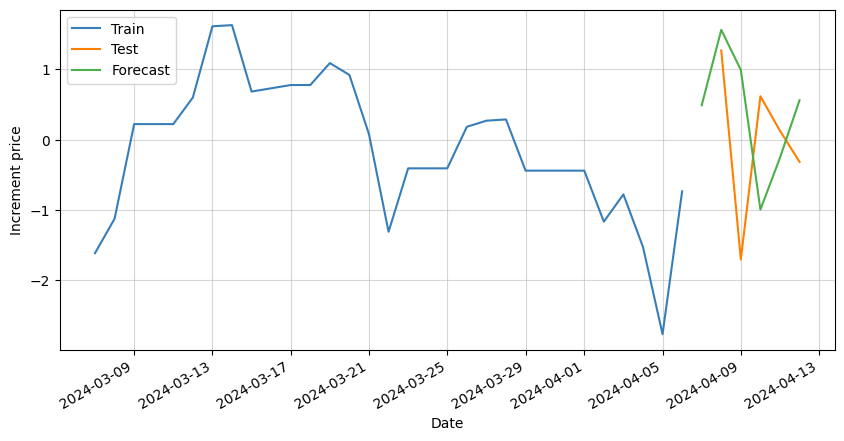

In [128]:
# Plot forecasted increment of cases
ax = df_scaled[-30:]['adj close sma'].plot(figsize=(10,5))
df_test_processed[:horizon]['adj close sma'].plot(ax=ax)
df_forecast['adj close sma'].plot(ax=ax)
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Increment price')
plt.legend(['Train', 'Test', 'Forecast'])
plt.show()

In [60]:
# Invert the transformations to bring it back to the original scale
df_forecast_original = df_inv_transformation(df_forecast, df_itau, scaler)

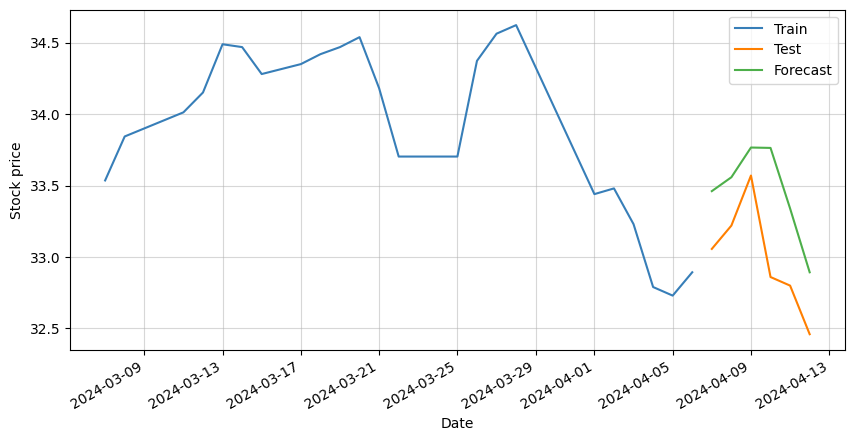

In [61]:
# Plot forecasted number of cases
ax = df_train[-30:]['adj close'].plot(figsize=(10,5))
df_test[:horizon]['adj close'].plot(ax=ax)
df_forecast_original['adj close'].plot(ax=ax)
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.legend(['Train', 'Test', 'Forecast'])
plt.show()